# 05 — Preprocessing

**Goal:** Prepare the engineered features for modelling.

**Inputs:** `../data/processed/featured_*.csv` · `../data/processed/feature_sets.json`

**Outputs:** `../data/processed/X_train_{pos}.csv` · `X_test_{pos}.csv` · `y_train_{pos}.csv` · `y_test_{pos}.csv` · `preprocessors.pkl` · `final_features.json`

**Next:** `06_baseline_models.ipynb`

---
**Design decisions:**
- Only players **with a valuation** are used for modelling (NaN `log_market_value` → dropped here)
- Train/test split happens **before** any encoding or scaling (prevents data leakage)
- `current_club_domestic_competition_id` → **target encoding** (mean `log_market_value` per league, computed on train only). With only 14 unique leagues this is clean and encodes league prestige directly.
- All numeric features scaled with **StandardScaler** (fit on train, applied to test)
- Scalers saved to `preprocessors.pkl` so predictions can be inverse-transformed in notebook 08

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

PROC_PATH    = '../data/processed/'
FIGURES_PATH = '../figures/'
os.makedirs(FIGURES_PATH, exist_ok=True)

RANDOM_STATE = 42
TEST_SIZE    = 0.20
CAT_COL      = 'current_club_domestic_competition_id'
ENC_COL      = 'league_mean_value'
TARGET       = 'log_market_value'

print('Imports OK')

Imports OK


## 1. Load Featured Data

In [2]:
with open(PROC_PATH + 'feature_sets.json') as f:
    FEATURE_SETS = json.load(f)

df_gk  = pd.read_csv(PROC_PATH + 'featured_gk.csv')
df_def = pd.read_csv(PROC_PATH + 'featured_def.csv')
df_mid = pd.read_csv(PROC_PATH + 'featured_mid.csv')
df_att = pd.read_csv(PROC_PATH + 'featured_att.csv')

print('Loaded featured data:')
for label, df in [('GK', df_gk), ('DEF', df_def), ('MID', df_mid), ('ATT', df_att)]:
    n_val = df[TARGET].notna().sum()
    print(f'  {label}: {len(df):>6,} players  ({n_val:,} with valuation)  {df.shape[1]} cols')

print(f'\nFeature set sizes: { {k: len(v) for k, v in FEATURE_SETS.items()} }')

Loaded featured data:
  GK:  3,745 players  (3,313 with valuation)  38 cols
  DEF: 10,714 players  (9,867 with valuation)  39 cols
  MID:  9,766 players  (8,976 with valuation)  38 cols
  ATT:  9,299 players  (8,554 with valuation)  39 cols

Feature set sizes: {'GK': 18, 'DEF': 19, 'MID': 18, 'ATT': 19}


## 2. Filter: Keep Only Labeled Players

Players without a market valuation cannot be used for supervised learning.
They will be re-introduced in notebook 09 (undervalued player detection) using the trained model.

In [3]:
labeled = {}
for label, df in [('GK', df_gk), ('DEF', df_def), ('MID', df_mid), ('ATT', df_att)]:
    d = df.dropna(subset=[TARGET]).copy()
    labeled[label] = d
    dropped = len(df) - len(d)
    print(f'  {label}: {len(df):>6,} total  →  {len(d):,} labeled  ({dropped:,} without valuation dropped)')

  GK:  3,745 total  →  3,313 labeled  (432 without valuation dropped)
  DEF: 10,714 total  →  9,867 labeled  (847 without valuation dropped)
  MID:  9,766 total  →  8,976 labeled  (790 without valuation dropped)
  ATT:  9,299 total  →  8,554 labeled  (745 without valuation dropped)


## 3. Train / Test Split

Split **before** any encoding or scaling. 80 % train · 20 % test · `random_state=42`.

In [4]:
splits = {}
for label, df in labeled.items():
    y = df[TARGET]
    X_train, X_test, y_train, y_test = train_test_split(
        df, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
    splits[label] = (X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy())
    print(f'  {label}: {len(X_train):,} train  /  {len(X_test):,} test  '
          f'(target mean: train={y_train.mean():.3f}, test={y_test.mean():.3f})')

  GK: 2,650 train  /  663 test  (target mean: train=12.098, test=12.137)
  DEF: 7,893 train  /  1,974 test  (target mean: train=12.696, test=12.653)
  MID: 7,180 train  /  1,796 test  (target mean: train=12.737, test=12.681)
  ATT: 6,843 train  /  1,711 test  (target mean: train=12.802, test=12.761)


## 4. Encode Categorical Feature

**Target encoding:** replace `current_club_domestic_competition_id` with the mean `log_market_value`
of that league — computed on the **training set only**.

This encodes league prestige (Premier League players are valued higher) as a single numeric column.
Unseen leagues (test set) fall back to the global training mean.

In [5]:
league_encodings = {}

for label, (X_train, X_test, y_train, y_test) in splits.items():
    global_mean = y_train.mean()
    league_map  = X_train.groupby(CAT_COL)[TARGET].mean().to_dict()

    X_train[ENC_COL] = X_train[CAT_COL].map(league_map).fillna(global_mean)
    X_test[ENC_COL]  = X_test[CAT_COL].map(league_map).fillna(global_mean)

    league_encodings[label] = {'map': league_map, 'global_mean': global_mean}
    splits[label] = (X_train, X_test, y_train, y_test)

    print(f'  {label}: {len(league_map)} leagues encoded')
    top3 = sorted(league_map.items(), key=lambda x: -x[1])[:3]
    print(f'    Top 3 leagues: { [(k, round(v,3)) for k,v in top3] }')

# Show league encoding for one position (same leagues across all)
print('\nLeague → mean log_market_value (GK):')
for league, val in sorted(league_encodings['GK']['map'].items(), key=lambda x: -x[1]):
    print(f'  {league:<8} {val:.3f}')

  GK: 14 leagues encoded
    Top 3 leagues: [('GB1', 13.349), ('FR1', 12.61), ('ES1', 12.577)]
  DEF: 14 leagues encoded
    Top 3 leagues: [('GB1', 14.029), ('L1', 13.509), ('ES1', 13.255)]
  MID: 14 leagues encoded
    Top 3 leagues: [('GB1', 13.958), ('ES1', 13.438), ('L1', 13.416)]
  ATT: 14 leagues encoded
    Top 3 leagues: [('GB1', 14.179), ('ES1', 13.72), ('L1', 13.465)]

League → mean log_market_value (GK):
  GB1      13.349
  FR1      12.610
  ES1      12.577
  L1       12.555
  PO1      12.200
  BE1      11.952
  IT1      11.903
  NL1      11.867
  GR1      11.862
  RU1      11.838
  SC1      11.828
  DK1      11.824
  UKR1     11.741
  TR1      11.520


## 5. Build Final Feature Matrices

Replace `current_club_domestic_competition_id` with `league_mean_value` in each feature set.

In [6]:
# Build FINAL_FEATURES: swap CAT_COL → ENC_COL
FINAL_FEATURES = {}
for label, feats in FEATURE_SETS.items():
    FINAL_FEATURES[label] = [ENC_COL if f == CAT_COL else f for f in feats]

print('Final feature sets (numeric only):')
for label, feats in FINAL_FEATURES.items():
    print(f'  {label} ({len(feats)} features): {feats}')

Final feature sets (numeric only):
  GK (18 features): ['age', 'age_squared', 'log_minutes', 'log_appearances', 'has_appearances', 'goals_per_90', 'assists_per_90', 'contributions_per_90', 'yellow_per_90', 'clean_sheets_per_90', 'log_highest_mv', 'log_total_fees', 'transfer_count', 'squad_size', 'league_mean_value', 'cs_rate', 'save_pct_proxy', 'gk_offensive']
  DEF (19 features): ['age', 'age_squared', 'log_minutes', 'log_appearances', 'has_appearances', 'goals_per_90', 'assists_per_90', 'contributions_per_90', 'yellow_per_90', 'clean_sheets_per_90', 'log_highest_mv', 'log_total_fees', 'transfer_count', 'squad_size', 'league_mean_value', 'def_cs_rate', 'defensive_solidity', 'def_attack_per_90', 'discipline_score']
  MID (18 features): ['age', 'age_squared', 'log_minutes', 'log_appearances', 'has_appearances', 'goals_per_90', 'assists_per_90', 'contributions_per_90', 'yellow_per_90', 'clean_sheets_per_90', 'log_highest_mv', 'log_total_fees', 'transfer_count', 'squad_size', 'league_mean

## 6. Scale Features

**StandardScaler** (zero mean, unit variance) fit on train, applied to test.
Necessary for linear models and distance-based methods; harmless for tree models.

In [7]:
scalers      = {}
scaled_splits = {}

for label, (X_train, X_test, y_train, y_test) in splits.items():
    feats  = FINAL_FEATURES[label]
    scaler = StandardScaler()

    X_train_sc = pd.DataFrame(
        scaler.fit_transform(X_train[feats]),
        columns=feats, index=X_train.index
    )
    X_test_sc = pd.DataFrame(
        scaler.transform(X_test[feats]),
        columns=feats, index=X_test.index
    )

    scalers[label]       = scaler
    scaled_splits[label] = (X_train_sc, X_test_sc, y_train, y_test)

    # Quick sanity: train means should be ≈ 0
    max_mean_dev = X_train_sc.mean().abs().max()
    print(f'  {label}: scaled {len(feats)} features  '
          f'(max |train mean| = {max_mean_dev:.2e})')

  GK: scaled 18 features  (max |train mean| = 3.50e-15)
  DEF: scaled 19 features  (max |train mean| = 1.65e-15)
  MID: scaled 18 features  (max |train mean| = 5.38e-15)
  ATT: scaled 19 features  (max |train mean| = 9.17e-16)


## 7. Target Distribution — Train vs Test

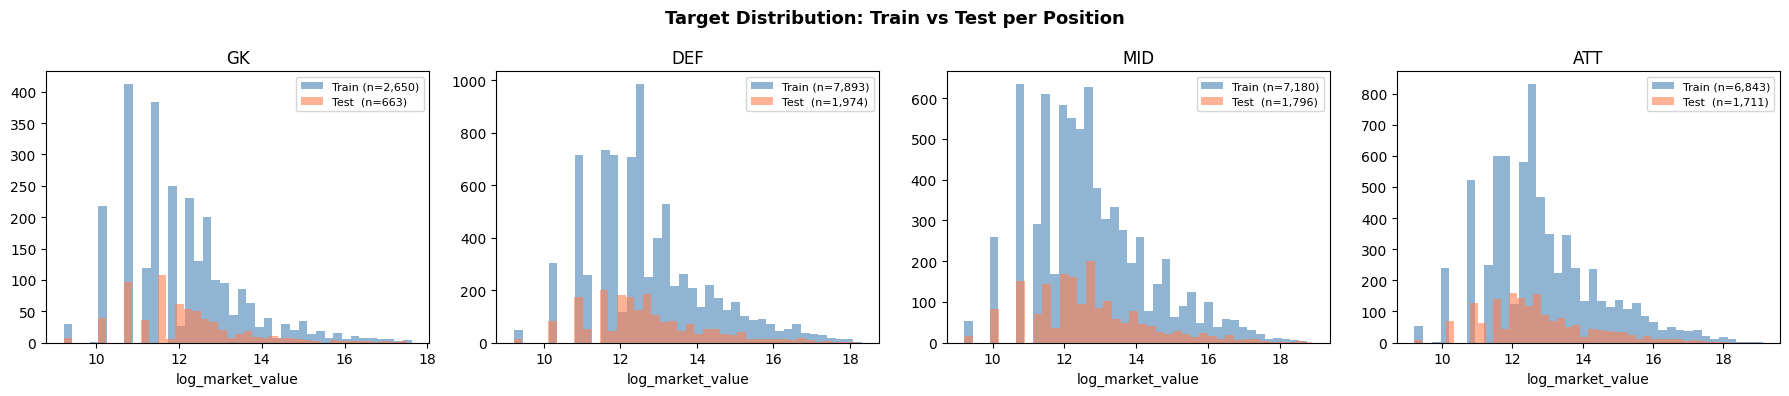

Saved figure.


In [8]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharey=False)

for ax, label in zip(axes, ['GK', 'DEF', 'MID', 'ATT']):
    _, _, y_train, y_test = scaled_splits[label]
    ax.hist(y_train, bins=40, alpha=0.6, label=f'Train (n={len(y_train):,})', color='steelblue')
    ax.hist(y_test,  bins=40, alpha=0.6, label=f'Test  (n={len(y_test):,})',  color='coral')
    ax.set_title(label)
    ax.set_xlabel('log_market_value')
    ax.legend(fontsize=8)

plt.suptitle('Target Distribution: Train vs Test per Position', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '05_train_test_target_distribution.png')
plt.show()
print('Saved figure.')

## 8. Validation

In [9]:
errors = []

for label in ['GK', 'DEF', 'MID', 'ATT']:
    X_train_sc, X_test_sc, y_train, y_test = scaled_splits[label]
    feats = FINAL_FEATURES[label]

    # 1. Feature columns match FINAL_FEATURES
    if list(X_train_sc.columns) != feats:
        errors.append(f'{label}: column mismatch in X_train')
    else:
        print(f'✓  {label}: columns match FINAL_FEATURES ({len(feats)} features)')

    # 2. No NaN in X
    nan_train = X_train_sc.isna().sum().sum()
    nan_test  = X_test_sc.isna().sum().sum()
    if nan_train > 0 or nan_test > 0:
        errors.append(f'{label}: NaN in features (train={nan_train}, test={nan_test})')
    else:
        print(f'✓  {label}: no NaN in X_train or X_test')

    # 3. No NaN in y
    if y_train.isna().any() or y_test.isna().any():
        errors.append(f'{label}: NaN in target')
    else:
        print(f'✓  {label}: no NaN in y_train or y_test')

    # 4. Row counts consistent
    if len(X_train_sc) != len(y_train) or len(X_test_sc) != len(y_test):
        errors.append(f'{label}: X/y row count mismatch')
    else:
        print(f'✓  {label}: X/y aligned  (train={len(y_train):,}, test={len(y_test):,})')

    # 5. Train/test ratio ≈ 80/20 (allow ±2%)
    total = len(y_train) + len(y_test)
    actual_test_frac = len(y_test) / total
    if not (0.18 <= actual_test_frac <= 0.22):
        errors.append(f'{label}: test fraction {actual_test_frac:.3f} outside expected 18–22%')
    else:
        print(f'✓  {label}: split ratio OK ({actual_test_frac:.1%} test)')

    # 6. Scaling: train column means ≈ 0 (tolerance 0.01)
    max_mean = X_train_sc.mean().abs().max()
    if max_mean > 0.01:
        errors.append(f'{label}: scaling failed — max train column mean = {max_mean:.4f}')
    else:
        print(f'✓  {label}: scaling OK (max |train mean| = {max_mean:.2e})')

    # 7. TARGET column not in feature matrix
    if TARGET in X_train_sc.columns:
        errors.append(f'{label}: target column leaking into X_train')
    else:
        print(f'✓  {label}: target not in feature matrix')

    print()

print('=' * 50)
if errors:
    print(f'FAILED — {len(errors)} issue(s):')
    for e in errors:
        print(f'  ✗  {e}')
else:
    print('ALL CHECKS PASSED ✓')
    print('Ready for notebook 06 — baseline models.')
print('=' * 50)

✓  GK: columns match FINAL_FEATURES (18 features)
✓  GK: no NaN in X_train or X_test
✓  GK: no NaN in y_train or y_test
✓  GK: X/y aligned  (train=2,650, test=663)
✓  GK: split ratio OK (20.0% test)
✓  GK: scaling OK (max |train mean| = 3.50e-15)
✓  GK: target not in feature matrix

✓  DEF: columns match FINAL_FEATURES (19 features)
✓  DEF: no NaN in X_train or X_test
✓  DEF: no NaN in y_train or y_test
✓  DEF: X/y aligned  (train=7,893, test=1,974)
✓  DEF: split ratio OK (20.0% test)
✓  DEF: scaling OK (max |train mean| = 1.65e-15)
✓  DEF: target not in feature matrix

✓  MID: columns match FINAL_FEATURES (18 features)
✓  MID: no NaN in X_train or X_test
✓  MID: no NaN in y_train or y_test
✓  MID: X/y aligned  (train=7,180, test=1,796)
✓  MID: split ratio OK (20.0% test)
✓  MID: scaling OK (max |train mean| = 5.38e-15)
✓  MID: target not in feature matrix

✓  ATT: columns match FINAL_FEATURES (19 features)
✓  ATT: no NaN in X_train or X_test
✓  ATT: no NaN in y_train or y_test
✓  ATT:

## 9. Save Outputs

In [10]:
for label in ['GK', 'DEF', 'MID', 'ATT']:
    X_train_sc, X_test_sc, y_train, y_test = scaled_splits[label]
    pos = label.lower()

    X_train_sc.to_csv(PROC_PATH + f'X_train_{pos}.csv', index=True)
    X_test_sc.to_csv( PROC_PATH + f'X_test_{pos}.csv',  index=True)
    y_train.to_csv(   PROC_PATH + f'y_train_{pos}.csv',  header=True)
    y_test.to_csv(    PROC_PATH + f'y_test_{pos}.csv',   header=True)

# Preprocessors (scalers + league encodings) — needed for notebook 08 inverse transform
preprocessors = {'scalers': scalers, 'league_encodings': league_encodings}
with open(PROC_PATH + 'preprocessors.pkl', 'wb') as f:
    pickle.dump(preprocessors, f)

# Final feature lists — loaded by notebook 06 and beyond
with open(PROC_PATH + 'final_features.json', 'w') as f:
    json.dump(FINAL_FEATURES, f, indent=2)

print(f'Saved to {os.path.abspath(PROC_PATH)}/')
print()
for fname in sorted(os.listdir(PROC_PATH)):
    size_kb = os.path.getsize(PROC_PATH + fname) / 1024
    print(f'  {fname:<35} {size_kb:>8.1f} KB')

Saved to /Users/giannisyfantidis/Documents/GitHub/football-player-value-predictor/data/processed/

  X_test_att.csv                         632.9 KB
  X_test_def.csv                         735.3 KB
  X_test_gk.csv                          235.0 KB
  X_test_mid.csv                         633.3 KB
  X_train_att.csv                       2530.4 KB
  X_train_def.csv                       2938.8 KB
  X_train_gk.csv                         939.1 KB
  X_train_mid.csv                       2530.0 KB
  feature_sets.json                        1.7 KB
  featured_att.csv                      2884.1 KB
  featured_def.csv                      3382.6 KB
  featured_gk.csv                        939.9 KB
  featured_mid.csv                      2949.3 KB
  final_features.json                      1.6 KB
  merged_att.csv                        1300.7 KB
  merged_complete.csv                   4720.5 KB
  merged_def.csv                        1515.4 KB
  merged_gk.csv                          522.5 KB
 